In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

from torchsummary import summary

In [15]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

mnist = fetch_openml('mnist_784', version=1)
X = mnist['data']
y = mnist['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

import torch

X_train = torch.Tensor(np.array(X_train)).view(-1, 1, 28, 28)
y_train = torch.LongTensor(np.array(y_train))
X_test = torch.Tensor(np.array(X_test)).view(-1, 1, 28, 28)
y_test = torch.LongTensor(np.array(y_test))


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to torch.Tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# Số classes trong tập MNIST
num_classes = 10 

# Số epoch
epochs = 1

# Các tham số cần thiết trong quá trình training
learning_rate = 0.001
batch_size = 128
display_step = 100

# Model path
checkpoint = 'model.pth'

# device: cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 3x(Conv2d -> ReLU) -> MaxPool -> Dropout -> Flatten -> 2x(Linear ->  ReLU) -> Linear
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=11*11*64, out_features=128) 
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        ### START CODE HEAR ≈ 18 lines
        ## 3x(Conv2d -> ReLU) -> MaxPool -> Dropout -> Flatten -> 2x(Linear ->  ReLU) -> Linear

        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        ### END CODE HERE
        return x

In [20]:
# Load model vào GPU
model = Net().to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 22, 22]          36,928
              ReLU-6           [-1, 64, 22, 22]               0
         MaxPool2d-7           [-1, 64, 11, 11]               0
           Dropout-8           [-1, 64, 11, 11]               0
           Flatten-9                 [-1, 7744]               0
           Linear-10                  [-1, 128]         991,360
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 64]           8,256
             ReLU-13                   [-1, 64]               0
           Linear-14                   

In [21]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss() # CrossEntropy
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam Optimizer set params=model.parameters(), lr=learning_rate
best_val_loss = 999

# Loop for each epoch
for epoch in range(1, epochs + 1):

    # Quá trình training 
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Clear gradients for this training step 
        optimizer.zero_grad()
        output = model(data)

        # Backpropagation, compute gradients
        loss = criterion(output, target)
        loss.backward()

        # Apply gradients
        optimizer.step()
        if batch_idx % display_step == 0:
            print('Train Epoch {}: [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # Quá trình testing 
    model.eval()
    test_loss = 0
    correct = 0
    # Set no grad cho quá trình testing
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = F.log_softmax(output, dim=1) # Sử dụng hàm log_sotmax để tính xác suất cho output
            test_loss += criterion(output, target) 
            pred = output.argmax(dim = 1, keepdim = True) # Sử dụng hàm argmax để lấy predicted label, chú ý: dim = 1, keepdim=True
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset) 
    if test_loss < best_val_loss:
      best_val_loss = test_loss
      torch.save(model.state_dict(), checkpoint)  # Lưu model path
      print("***********    TEST_ACC = {:.2f}%    ***********".format(correct/100))

Train Epoch 1: [0/56000 (0%)]	Train Loss: 2.769090
Train Epoch 1: [3200/56000 (6%)]	Train Loss: 0.449475
Train Epoch 1: [6400/56000 (11%)]	Train Loss: 0.160228
Train Epoch 1: [9600/56000 (17%)]	Train Loss: 0.122669
Train Epoch 1: [12800/56000 (23%)]	Train Loss: 0.004734
Train Epoch 1: [16000/56000 (29%)]	Train Loss: 0.306578
Train Epoch 1: [19200/56000 (34%)]	Train Loss: 0.182485
Train Epoch 1: [22400/56000 (40%)]	Train Loss: 0.004591
Train Epoch 1: [25600/56000 (46%)]	Train Loss: 0.149170
Train Epoch 1: [28800/56000 (51%)]	Train Loss: 0.321630
Train Epoch 1: [32000/56000 (57%)]	Train Loss: 0.042211
Train Epoch 1: [35200/56000 (63%)]	Train Loss: 0.036035
Train Epoch 1: [38400/56000 (69%)]	Train Loss: 0.083660
Train Epoch 1: [41600/56000 (74%)]	Train Loss: 0.039616
Train Epoch 1: [44800/56000 (80%)]	Train Loss: 0.285082
Train Epoch 1: [48000/56000 (86%)]	Train Loss: 0.004530
Train Epoch 1: [51200/56000 (91%)]	Train Loss: 0.004854
Train Epoch 1: [54400/56000 (97%)]	Train Loss: 0.021043
*

In [22]:
# Load lại model đã train
model.load_state_dict(torch.load(checkpoint))

# Xem lại thông số của model 
model.eval()

Net(
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=7744, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [27]:
# Lấy ra một batch trong tập test
item = iter(test_loader)
data, target = next(item)

# Lấy random index của một phần tử trong batch đó
test_idx = random.choice(range(len(data)))

# Lấy một ví dụ trong tập test
data = data[test_idx]
target = target[test_idx]
assert data.shape == (1, 28, 28)

In [28]:
# Predict sử dụng model đã train
def plot(data, model):
  data = torch.unsqueeze(data, dim=0) # unsqueeze data
  data = data.to(device)
  output = model(data)
  output = F.log_softmax(output, dim=1) # log softmax, chú ý dim
  pred = output.argmax(dim=1, keepdim=True) # argmax, chú ý keepdim, dim=1
  print("Predict Number : ", pred[0][0].detach().cpu().numpy()) 
  plt.imshow(data[0][0].detach().cpu().numpy(), cmap='gray')
  plt.show()

Predict Number :  4


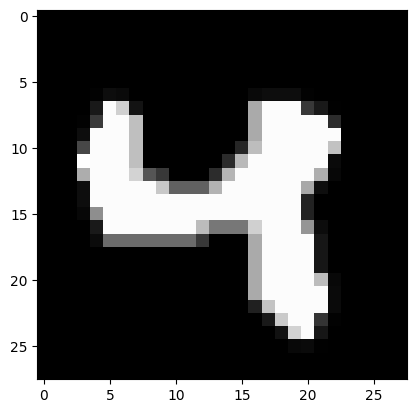

In [29]:
plot(data, model)

In [32]:
import torch
from PIL import Image
import numpy as np

# Load the PyTorch model from the .pth file
model_1 = torch.load('model.pth')

# Load the image and convert it to a grayscale numpy array
img = Image.open("/content/gamma_93081.jpg").convert("L")
img = img.resize((28, 28), Image.ANTIALIAS) 
img_array = np.array(img)

# Normalize the pixel values to be between 0 and 1
img_array = img_array.astype(np.float32) /255.0

# Convert the numpy array to a PyTorch tensor
img_tensor = torch.from_numpy(img_array)

# Reshape the PyTorch tensor to match the expected input shape of the model
img_tensor = img_tensor.reshape((1, 1, 28, 28))

# Make a using the PyTorch model
with torch.no_grad():
    output = model(img_tensor)
    
# Get the predicted digit by selecting the class with the highest output probability
predicted_digit = torch.argmax(output).item()

print("Predicted Digit:", predicted_digit)

Predicted Digit: 4
